# Install environment dependencies

In [1]:
# !conda create -n name python=3.10
# !conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia
# !conda install matplotlib numpy scipy scikit-learn
# !conda install -c conda-forge deepxdey

In [1]:
import numpy as np
import os

import torch
from torch import nn
from torch.nn import functional as F
import deepxde.deepxde as dde
from deepxde.deepxde.nn.pytorch.deeponet import DeepONet

from utils.func import *

import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
# Config
testing = True # testing the code or not
if testing:
    n_init = 50 # number of v(x) use to pre-train the model
    n_0 = 100 # number of v(x) would be selected from the training data
    n_1 = 20 # number of v(x) in n0 would be used to train the model
    n_2 = 200 # total v(x) would be used to train the model

    batchsize = 5000 # batchsize for training, 5000 for testing the code. Defaults to 20000.
    iteration = 5000 # iteration for training, 5000 for testing the code. Defaults to 30000.
    shuf_dataset = True # shuffle the dataset or not

    lr = 1e-3 # learning rate
    decay_step = iteration // 5 # decay step, using inverse time decay 
    decay_rate = 0.5
else:
    n_init = 20 # number of v(x) use to pre-train the model
    n_0 = 100 # number of v(x) would be selected from the training data
    n_1 = 20 # number of v(x) in n0 would be used to train the model
    n_2 = 200 # total v(x) would be used to train the model

    batchsize = 20000 # batchsize for training, 5000 for testing the code. Defaults to 20000.
    iteration = 30000 # iteration for training, 5000 for testing the code. Defaults to 30000.
    shuf_dataset = True # shuffle the dataset or not

    lr = 1e-3 # learning rate
    decay_step = iteration // 5 # decay step, using inverse time decay 
    decay_rate = 0.5

# Network understanding
Input function $u$ is the unknown function given by the sensor. Every sensor has a different location, so the input function can be approximated by these sensors. Let the $i$-th sensor be located at $\bm{x_i}$. Then the input function is $u(\bm{x_i})$.

Therefore, if we have 100 sensors, we have 100 values of $u_i = u(\bm{x_i})$. Then the Branch net would use these 100 $u_i$ as inputs and output given number of $b_i$.

For the Trunk net, since we got the $\bm{x_i}$ for every sensor, we could make use of these $\bm{x_i}$ to train the Trunk net. The Trunk net takes $\bm{x_i}$ as input and output $t_i$.

Finally, the deepONet output is:
$$ \sum_i{b_it_i} + b_0. $$

# Data for this problem
The goal of us is to solve $u(x,t)$ by the following equation and given $v(x)$.
$$ \frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} + ku^2 + v(x), \quad x,t \in [0,1]$$

Here, we sample the points $\bm{x} = (x,t)$ uniformly in $[0,1] \times [0,1]$. And we provide 1000 different $v(x)$, each one has 101 uniformly sampled points in $[0,1]$. For $u(x,t)$, we have 10201 uniformly sampled points in $[0,1] \times [0,1]$. 

In [4]:
train_data = np.load("dr_train_ls0.1.npz")
test_data = np.load("dr_test_ls0.1.npz")

print(train_data)
print(test_data)

train_vx = train_data["X_train0"]
train_grid = train_data["X_train1"]
train_uxt = train_data["y_train"]

if shuf_dataset:
    order = np.random.permutation(train_vx.shape[0])
    train_vx = train_vx[order]
    train_uxt = train_uxt[order]

print(f'xtrain0: {train_vx.shape}, dtype: {train_vx.dtype}\nxtrain1: {train_grid.shape}, dtype: {train_grid.dtype}\nytrain: {train_uxt.shape}, dtype: {train_uxt.dtype}')

X_test = (np.repeat(test_data["X_test0"], 10201, axis=0).astype(np.float32), np.tile(test_data["X_test1"], (100, 1)).astype(np.float32))
y_test = test_data["y_test"].reshape(-1, 1).astype(np.float32)

print("data shape:")
print(f"x_test[0]: {X_test[0].shape}, dtype: {X_test[0].dtype}\nx_test[1]: {X_test[1].shape}, dtype: {X_test[1].dtype}\ny_test: {y_test.shape}, dtype: {y_test.dtype}")

NpzFile 'dr_train_ls_0.1_101_101.npz' with keys: X_train0, X_train1, y_train
NpzFile 'dr_test_ls_0.1_101_101.npz' with keys: X_test0, X_test1, y_test
xtrain0: (1000, 101), dtype: float64
xtrain1: (10201, 2), dtype: float64
ytrain: (1000, 10201), dtype: float64
data shape:
x_test[0]: (1020100, 101), dtype: float32
x_test[1]: (1020100, 2), dtype: float32
y_test: (1020100, 1), dtype: float32


# Visualization
Here we visualize all the $u(x,t)$ and $v(x)$.

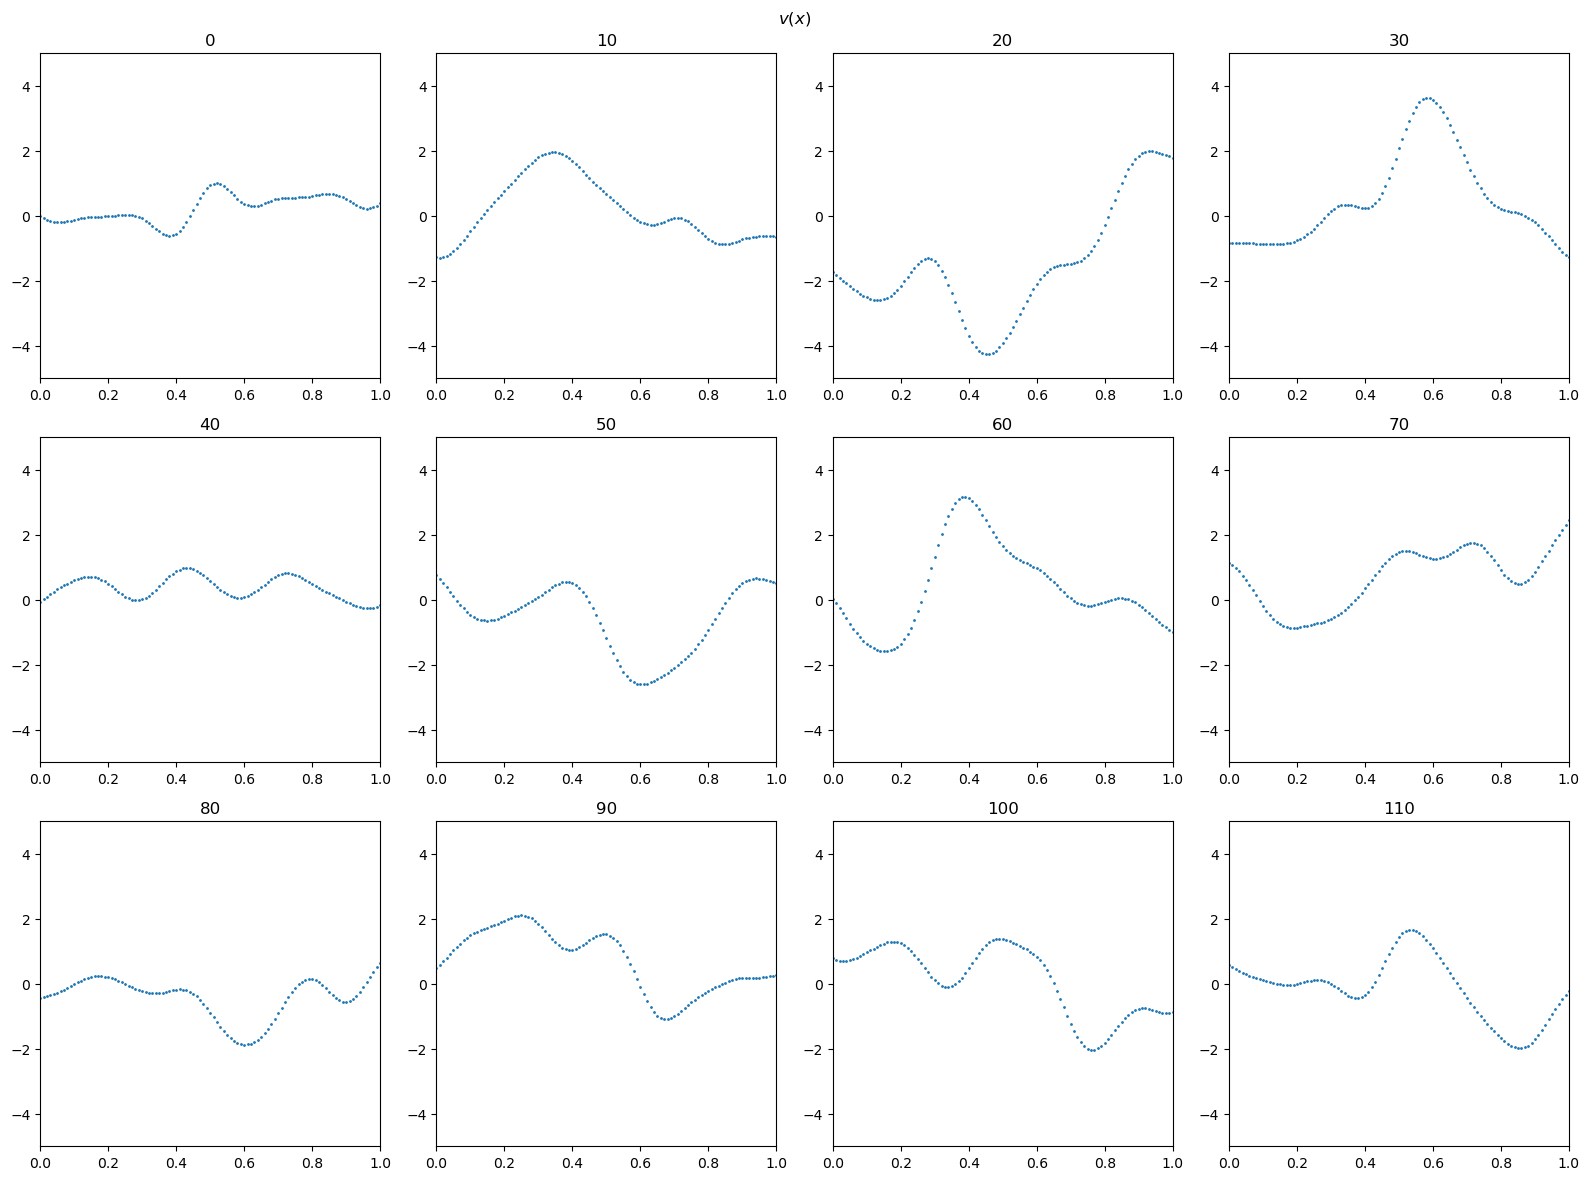

In [5]:
shows = range(0, 120, 10)
num = len(shows)
fig, axs = plt.subplots(int(np.ceil(num / 4)), 4)
fig.suptitle("$v(x)$")
fig.set_size_inches(4 * 4, int(np.ceil(num / 4)) * 4)
for i, index in enumerate(shows):
    ax = axs[i // 4, i % 4]
    ax.set_title(f"{index}")
    ax.set_xlim([0, 1])
    ax.set_ylim([-5, 5])
    x = np.linspace(0, 1, 101)
    y = train_data["X_train0"][index]
    ax.scatter(x, y, s=1)
plt.tight_layout()
plt.show()

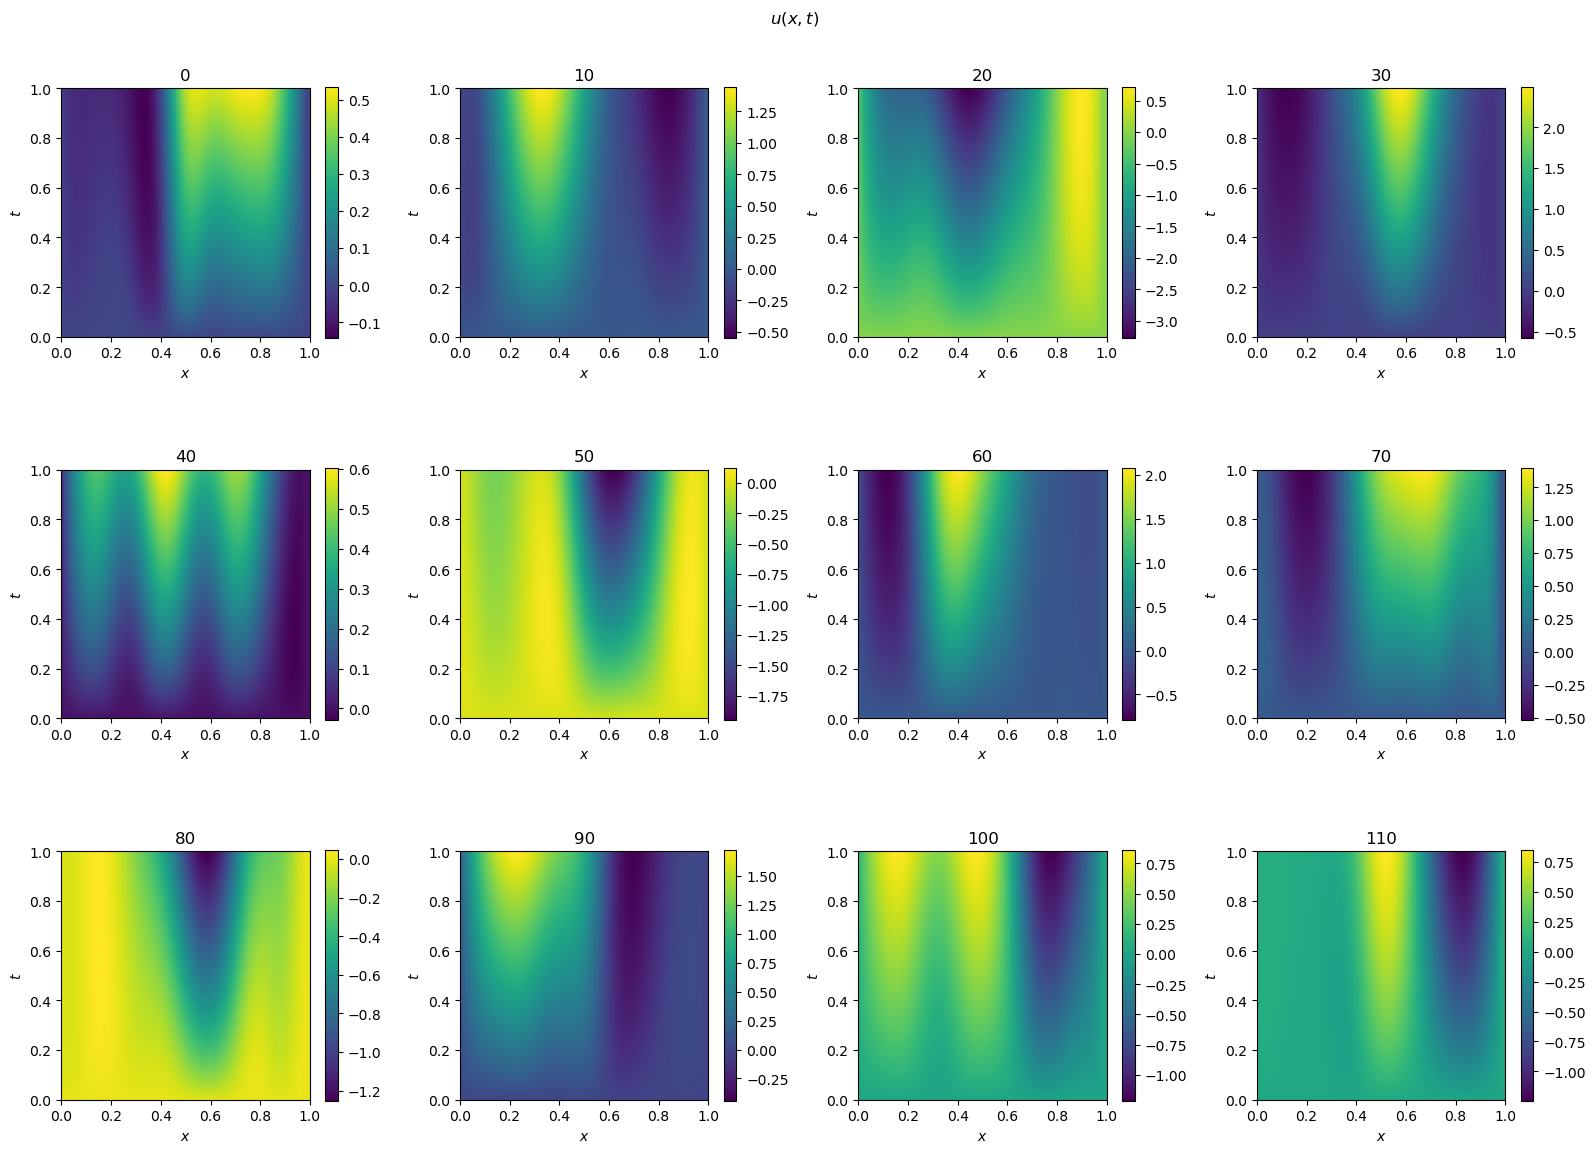

In [6]:
fig, axs = plt.subplots(int(np.ceil(num / 4)), 4)
fig.suptitle("$u(x,t)$")
fig.set_size_inches(4 * 4, int(np.ceil(num / 4)) * 4)
for i, index in enumerate(shows):
    ax = axs[i // 4, i % 4]
    ax.set_title(f"{index}")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    scatter = ax.scatter(train_data["X_train1"][:, 0], train_data["X_train1"][:, 1], c=train_data["y_train"][index])
    colorbar = plt.colorbar(scatter, ax = ax, shrink=0.7)

plt.tight_layout()
plt.show()

In [7]:
indices = np.arange(n_init) if shuf_dataset else index_gen0()
metrics_list = []

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

net = DeepONet(
        layer_sizes_branch= [101, 100, 100, 100],
        layer_sizes_trunk= [2, 100, 100, 100],
        activation= {"branch": F.relu, "trunk": F.gelu},
        kernel_initializer= "Glorot normal"
    )

net.apply_output_transform(dirichlet)

len_input = len(indices) # 50

X_train = (np.repeat(train_vx[indices], 10201, axis=0).astype(np.float32), 
           np.tile(train_grid, (len_input, 1)).astype(np.float32))
y_train = train_uxt[indices].reshape(-1, 1).astype(np.float32)

print(f"data shape:\nxtrain0: {X_train[0].shape}, dtype: {X_train[0].dtype}\nxtrain1: {X_train[1].shape}, dtype: {X_train[1].dtype}\nytrain: {y_train.shape}, dtype: {y_train.dtype}")
data = dde.data.Triple(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
model = dde.Model(data, net)
model.compile("adam", lr=lr, metrics=[mean_l2_rel_err], decay = (torch.optim.lr_scheduler.LambdaLR, [], {"lr_lambda": lambda step: 1 / (1 + decay_rate * (step / decay_step))}))

data shape:
xtrain0: (510050, 101), dtype: float32
xtrain1: (510050, 2), dtype: float32
ytrain: (510050, 1), dtype: float32
Compiling model...
'compile' took 0.000265 s



In [8]:
# First train without any techniques
os.makedirs("model", exist_ok=True)
checker = dde.callbacks.ModelCheckpoint("model/model0.ckpt", save_better_only=False, period=1000)

loss_history, train_state = model.train(iterations = iteration,
                                        callbacks = [checker],
                                        batch_size = batchsize
                                        )

metrics_test = np.array(loss_history.metrics_test).reshape(-1, 1)

np.savetxt('metrics0.txt', metrics_test)

metrics_list.append(metrics_test)
    

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.19e+00]    [1.10e+00]    [3.02e+00]    
1000      [1.42e-02]    [1.01e-01]    [8.28e-01]    
2000      [1.30e-02]    [1.03e-01]    [8.24e-01]    
3000      [1.17e-02]    [9.90e-02]    [8.24e-01]    
4000      [3.98e-03]    [1.04e-01]    [8.37e-01]    
5000      [2.08e-03]    [1.12e-01]    [8.55e-01]    

Best model at step 5000:
  train loss: 2.08e-03
  test loss: 1.12e-01
  test metric: [8.55e-01]

'train' took 61.636631 s



# Work flow
1. pretrain with 50 $v(x)$
2. add top the 10 lagerest loss for new 50 $v(x)$ into training set, repeat 19 times.

In [13]:
def pde(inputs: tuple[torch.Tensor, torch.Tensor], outputs: torch.Tensor) -> torch.Tensor:
    """
    _summary_

    Args:
        inputs (tuple[torch.Tensor, torch.Tensor]): include the sensor values and the points, their shapes are (B, N) and (B, 2) respectively.
        outputs (torch.Tensor): the output of the network, its shape is (B, 1).

    Returns:
        torch.Tensor: the residual of the PDE, its shape is (B, 1).
    """
    sensor_values, points = inputs # 50 x 101, 10000 x 2, out: 50 x 10000
    # outputs = outputs.view(-1, 1)
    dy_t = dde.grad.jacobian(outputs, points, i=0, j=1)
    dy_xx = dde.grad.hessian(outputs, points, i=0, j=0)
    
    sensor_values = sensor_values[:, None, ...] # 10000, 1, 101 (B, C, Nin)
    z = grid_sample(sensor_values, points[:,None,(0,)], mode="linear", padding_mode="border", align_corners=True)[...,0] # 1, 10000, 1
    return (dy_t - 0.01 * dy_xx - 0.01 * outputs ** 2 - z)

def select(net: nn.Module, sensor_values: np.ndarray, points_each_sensor: int = 10000):
    """
    Caclculate the residual of the PDE using a list of sensor values The largerest k values would be added to the next training process.

    Args:
        sensor_value (np.ndarray): shape: (1, 101)

    Returns:
        _type_: _description_
    """
    if sensor_values.ndim == 1:
        sensor_values = sensor_values[None, :]
    
    data_pde = dde.data.TimePDE(geomtime, pde, [], num_domain = 2500, num_test = 10000) # tuple[x, u(x), aux_function(x)]
    
    model = dde.Model(data_pde, net)

    X = geomtime.random_points(points_each_sensor) # 10000, 2(x,t)
    
    sensor_values = sensor_values.repeat(points_each_sensor, axis = 0) # 10000 101
    
    residual = model.predict((sensor_values, X), operator=pde)
    
    residual = np.abs(residual).mean()

    return residual

i = n_init
while len(indices) < n_2:
    residual_list = np.asarray([select(net, sensor_value) for sensor_value in train_vx[i:i + n_0]])
    err_eq = torch.from_numpy(residual_list)
    selected_vx = torch.topk(err_eq, min(n_1, n_2 - len(indices)), dim=0)[1].numpy() + i
    i += n_0
    indices = np.concatenate([indices, selected_vx], 0)
    
    X_train = (np.repeat(train_vx[indices], 10201, axis=0).astype(np.float32), np.tile(train_grid, (len(indices), 1)).astype(np.float32))
    y_train = train_uxt[indices].reshape(-1, 1).astype(np.float32)
    
    data = dde.data.Triple(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    model = dde.Model(data, net)
    model.compile("adam", lr=lr, metrics=[mean_l2_rel_err], decay = (torch.optim.lr_scheduler.LambdaLR, [], {"lr_lambda": lambda step: 1 / (1 + decay_rate * (step / decay_step))}))
    
    print(f"Now training with {len(indices)} data")
    losshistory, train_state = model.train(iterations = iteration if len(indices) < n_2 else 50000, callbacks = [checker], batch_size = batchsize)
        
    metrics_test = np.array(losshistory.metrics_test).reshape(-1, 1)
    np.savetxt(f'metrics{i}.txt', metrics_test)
    metrics_list.append(metrics_test)
    
print(indices)
np.savetxt('index.txt', indices)
np.savetxt('order.txt', order if order is not None else np.arange(1000))
metrics_list = np.concatenate(metrics_list, axis=0)
np.savetxt('metrics.txt', metrics_list)

Compiling model...
'compile' took 0.000566 s

Now training with 70 data
Training model...

0         [3.94e-03]    [8.23e-02]    [7.75e-01]    


KeyboardInterrupt: 

: 

In [ ]:
X_train = (np.repeat(train_data["X_train0"][indices], 10201, axis=0).astype(np.float32), 
           np.tile(train_data["X_train1"], (len_input, 1)).astype(np.float32))
y_train = train_data["y_train"][indices].reshape(-1, 1).astype(np.float32)

data = dde.data.Triple(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
model = dde.Model(data, net)
model.compile("adam", lr=lr)
model.restore("model/model0.ckpt-50000.pt", verbose=1)

index = 0

v_x = test_data["X_test0"][index] # 101
u_gt = test_data["y_test"][index]

X = test_data["X_test1"] # 10201, 2

sensor_value = v_x[None, :].repeat(10201, axis=0) # 10201, 101

u_pd = model.predict((sensor_value, X))[:,0] # 10201, 1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
fig.suptitle("$u(x,t)$")
fig.set_size_inches(4 * 3,  4)
ax1.set_title(f"{index}_gt")
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_aspect('equal')
ax1.set_xlabel("$x$")
ax1.set_ylabel("$t$")
scatter = ax1.scatter(X[:,0], X[:, 1], c=u_gt)
colorbar = plt.colorbar(scatter, ax = ax1, shrink=0.7)

ax2.set_title(f"{index}_pd")
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_aspect('equal')
ax2.set_xlabel("$x$")
ax2.set_ylabel("$t$")
scatter = ax2.scatter(X[:,0], X[:, 1], c=u_pd)
colorbar = plt.colorbar(scatter, ax = ax2, shrink=0.7)

ax3.set_title(f"{index}_delta")
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
ax3.set_aspect('equal')
ax3.set_xlabel("$x$")
ax3.set_ylabel("$t$")
scatter = ax3.scatter(X[:,0], X[:, 1], c=u_pd - u_gt)
colorbar = plt.colorbar(scatter, ax = ax3, shrink=0.7)

plt.tight_layout()
plt.show()

In [ ]:
dde.data.PDEOperator()
dde.data.function_spaces.FunctionSpace()
dde.data.PDE()
dde.data.TripleCartesianProd()
dde.data.Triple()
dde.data.PDEOperatorCartesianProd()
# implement customFuncSpace()

# implement customFuncTriple()
# 1. randomly choose N func, each func has M points. 2. randomly choose R points. 3. 


tensor([[[[-1.0000, -1.0000],
          [-1.0000, -0.8947],
          [-1.0000, -0.7895],
          [-1.0000, -0.6842],
          [-1.0000, -0.5789],
          [-1.0000, -0.4737],
          [-1.0000, -0.3684],
          [-1.0000, -0.2632],
          [-1.0000, -0.1579],
          [-1.0000, -0.0526],
          [-1.0000,  0.0526],
          [-1.0000,  0.1579],
          [-1.0000,  0.2632],
          [-1.0000,  0.3684],
          [-1.0000,  0.4737],
          [-1.0000,  0.5789],
          [-1.0000,  0.6842],
          [-1.0000,  0.7895],
          [-1.0000,  0.8947],
          [-1.0000,  1.0000]]]])


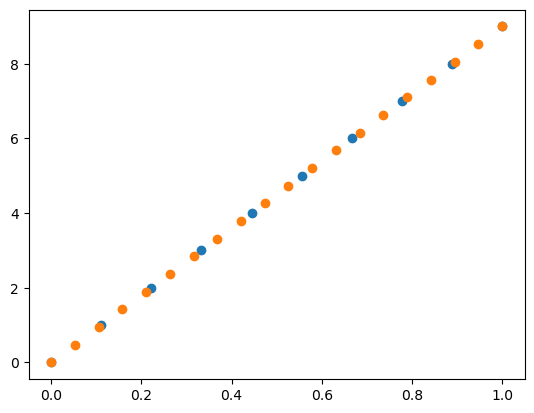

In [ ]:
a = torch.tensor([0.3, 0.2])
a = torch.linspace(-1, 1, 20)
a = a[None,:, None] # 1, 2, 1
value = torch.arange(0, 10).float()
value = value[None, None, :] # 1, 1, 10
sample = grid_sample(value, a, "linear", padding_mode="border", align_corners=True)

plt.scatter(torch.linspace(0, 1, 10).cpu(), value[0,0].cpu())
plt.scatter((a[0,:,0].cpu() + 1)/2, sample[0,0].cpu())

In [7]:
import torch
a = torch.randn(100)
std = torch.std(a)
(a > a.mean() + std).nonzero()[:,0]

tensor([ 0, 11, 14, 38, 42, 43, 44, 48, 55, 56, 60, 68, 69, 88, 90, 99])

In [18]:
from tensorboard.backend.event_processing import event_accumulator

ea = event_accumulator.EventAccumulator('runs/test/events.out.tfevents.1689164364.gpu02.hpc.pku.edu.cn.11735.0')

ea.Reload()

print(ea.Tags())

ea.Distributions("pde_res")

{'images': ['$v(x)$', '$u(x,t)$', '$u(x,t)$_0'], 'audio': [], 'histograms': ['select_pde', 'pde_res', 'l2_rel'], 'scalars': ['loss_mse', 'lr', 'grad'], 'distributions': ['select_pde', 'pde_res', 'l2_rel'], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


[HistogramEvent(wall_time=1689166394.985045, step=230000, histogram_value=HistogramValue(min=0.0026458303909748793, max=0.0693921148777008, num=100.0, sum=1.305840628221631, sum_squares=0.03366010425987439, bucket_limit=[0.0024896570713318863, 0.002738622778465075, 0.0030124850563115826, 0.003313733561942741, 0.0036451069181370156, 0.004009617609950718, 0.00441057937094579, 0.00485163730804037, 0.005336801038844407, 0.005870481142728848, 0.006457529257001733, 0.007103282182701907, 0.007813610400972098, 0.008594971441069308, 0.00945446858517624, 0.010399915443693864, 0.01143990698806325, 0.012583897686869577, 0.013842287455556535, 0.01522651620111219, 0.01674916782122341, 0.018424084603345752, 0.02026649306368033, 0.022293142370048362, 0.0245224566070532, 0.026974702267758523, 0.02967217249453438, 0.03263938974398782, 0.035903328718386605, 0.03949366159022527, 0.043443027749247805, 0.04778733052417259, 0.052566063576589855, 0.057822669934248845, 0.06360493692767373, 0.06996543062044111]

In [5]:
"""Backend supported: tensorflow.compat.v1"""
import deepxde.deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import torch

# PDE
def pde(x, y, v):
    dy_x = dde.grad.jacobian(y, x, j=0)
    dy_t = dde.grad.jacobian(y, x, j=1)
    return dy_t + dy_x


geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


def func_ic(x, v):
    return v


ic = dde.icbc.IC(geomtime, func_ic, lambda _, on_initial: on_initial)

pde = dde.data.TimePDE(geomtime, pde, ic, num_domain=250, num_initial=50, num_test=500)

# Function space
func_space = dde.data.GRF(kernel="ExpSineSquared", length_scale=1)

# Data
eval_pts = np.linspace(0, 1, num=50)[:, None]
data = dde.data.PDEOperatorCartesianProd(
    pde, func_space, eval_pts, 1000, function_variables=[0], num_test=100, batch_size=32
)

# Net
net = dde.nn.DeepONetCartesianProd(
    [50, 128, 128, 128],
    [5, 128, 128, 128],
    "tanh",
    "Glorot normal",
)


def periodic(x):
    x, t = x[:, (0,)], x[:, (1,)]
    x = x * 2 * np.pi
    return torch.cat((x.cos(), x.sin(), (2*x).cos(), (2*x).sin(), t), dim = 1)


net.apply_feature_transform(periodic)

model = dde.Model(data, net)
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=50000)
dde.utils.plot_loss_history(losshistory)

x = np.linspace(0, 1, num=100)
t = np.linspace(0, 1, num=100)
u_true = np.sin(2 * np.pi * (x - t[:, None]))
plt.figure()
plt.imshow(u_true)
plt.colorbar()

v_branch = np.sin(2 * np.pi * eval_pts).T
xv, tv = np.meshgrid(x, t)
x_trunk = np.vstack((np.ravel(xv), np.ravel(tv))).T
u_pred = model.predict((v_branch, x_trunk))
u_pred = u_pred.reshape((100, 100))
plt.figure()
plt.imshow(u_pred)
plt.colorbar()
plt.show()
print(dde.metrics.l2_relative_error(u_true, u_pred))

Compiling model...
'compile' took 0.000339 s

Training model...



TypeError: 'NoneType' object is not subscriptable

In [3]:
import torch
import time
from torch.utils.data import DataLoader, RandomSampler
from dataset import prepareData
vxs = torch.randn(10, 101)
x = torch.randn(10201, 2)
uxts = torch.randn(10, 10201)

data = prepareData(vxs, x, uxts)
dataset = DataLoader(data, batch_size = 1000, sampler = RandomSampler(data, generator=torch.Generator(torch.device("cuda:0"))))

In [5]:
for batch in dataset:
    pass

torch.Size([1000, 101])
torch.Size([1000, 2])
torch.Size([1000, 1])
